# Описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### План работы

1. Подготовка и анализ данных
2. Предобработка данных
3. Обучение моделей
4. Вывод

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**Метрика - MAE**

### Импорт библиотек

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore') 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

RND = 12345

## 1. Подготовка и анализ данных

In [2]:
arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
def check_data(data):
    display(data.head(5))
    display(data.tail(5))
    print(data.info())
    print(data.describe())

**Данные об электродах**

In [4]:
check_data(arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             0.637371
max     3241.000000           3.731596             2.676388


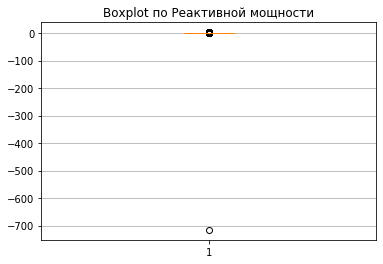

In [5]:
plt.boxplot(arc['Реактивная мощность'])
plt.grid(axis='y')
plt.title('Boxplot по Реактивной мощности')
plt.show()

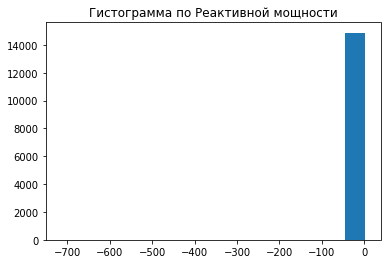

In [6]:
plt.hist(arc['Реактивная мощность'], bins=15)
plt.title('Гистограмма по Реактивной мощности')
plt.show()

Отрицательные значения в столбце Реактивная мощность, возможно возникли по причине ошибок. 

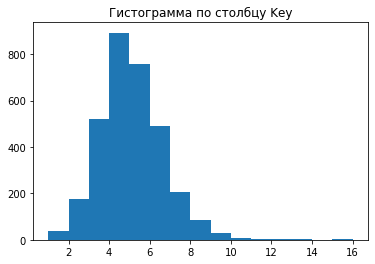

In [7]:
plt.hist((list(arc['key'].value_counts())), bins=15)
plt.title('Гистограмма по столбцу Key')
plt.show()

Столбец key содержит номер партии. Количество итераций варьируется от 1 до 16 для каждой партии. 

**Заметки**

* Уберем отрицательные значения в столбце Реактивная мощность
* Изменим формат данных на datetime в столбцах Начало нагрева дугой и Конец нагрева дугой
* Создадим признак Продолжительность нагрева дугой
* Создадим признак Полной мощности

Для создания параметра Полная мощность необходимо применить формулу: 

$$ S=\sqrt{P^2+Q^2} $$
 
где: P — активная мощность,  Q — реактивная мощность

**Данные о подаче сыпучих материалов (объём)**

In [8]:
check_data(bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.00

In [9]:
len(bulk['key'].unique())

3129

3129 уникальных номеров партий. Каждому значению соответсвует одна строка 

**Заметки**

* Отсутствуют дубликаты
* Множество пропусков. Обусловлено спецификой технологического процесса.
* Заменим пустые значения на 0

**Данные о подаче сыпучих материалов (время)**

In [10]:
check_data(bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None
               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000


**Данные о продувке сплава газом**

In [11]:
check_data(gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


In [12]:
len(gas['key'].unique())

3239

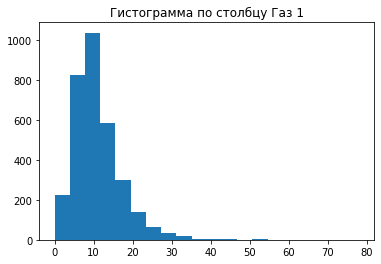

In [13]:
plt.hist((list(gas['Газ 1'])), bins=20)
plt.title('Гистограмма по столбцу Газ 1')
plt.show()

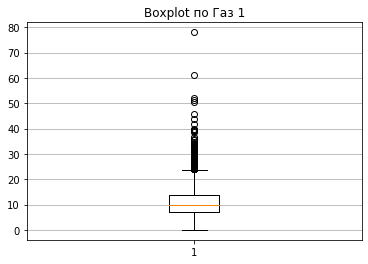

In [14]:
plt.boxplot(gas['Газ 1'])
plt.grid(axis='y')
plt.title('Boxplot по Газ 1')
plt.show()

**Заметки**

* Объем затраченного газа на каждую партию
* Распределение на гистограмме по столбцу Газ 1 выглядит нормальным, пик приходится на 10

**Результаты измерения температуры**

In [15]:
check_data(temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Время замера,Температура
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None
                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000


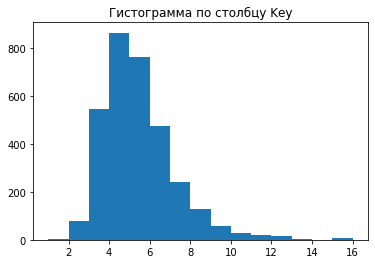

In [16]:
plt.hist((list(temp['key'].value_counts())), bins=15)
plt.title('Гистограмма по столбцу Key')
plt.show()

Количество итераций варьируется от 1 до 16 для каждой партии

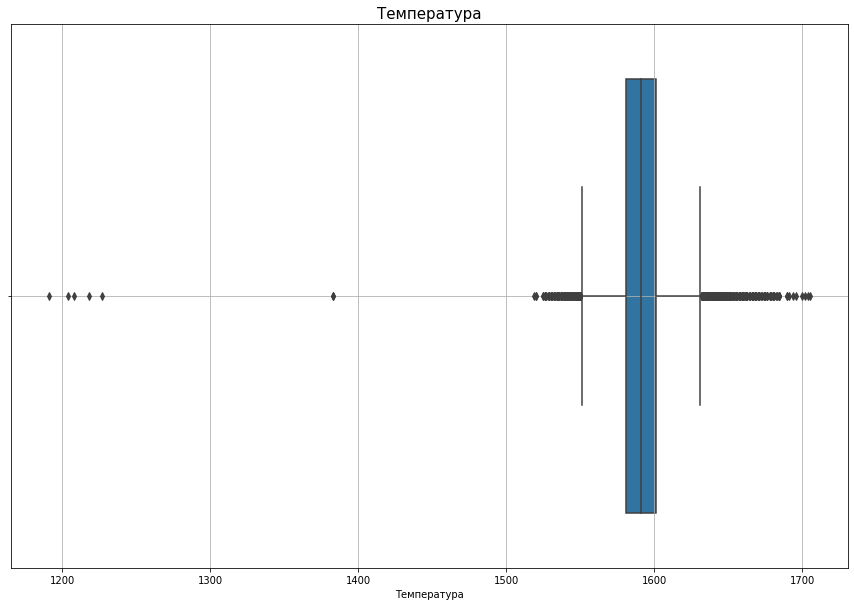

In [17]:
plt.figure(figsize=(15,10))
sns.boxplot(temp['Температура'])
plt.title('Температура', fontsize=15)
plt.grid(True)
plt.show()

In [18]:
len(temp[temp['Температура'].isnull()])

2901

In [19]:
temp[temp['Температура'].isnull()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


**Заметки**

* На каждую партию (key) приходятся несколько температурных замеров
* В некоторых партиях отсутствуют замеры температуры

**Данные о проволочных материалах (объём)**

In [20]:
check_data(wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194

**Заметки**

* Большое количество пропусков обусловлены спецификой производства
* Заменить пропуски на 0

**Данные о проволочных материалах (время)**

In [21]:
check_data(wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000


**Заметки**

* Изменим тип данных на datetime
* Множественные пропуски обусловлены спецификой производства

Нам необходимо проделать следующие шаги:

1. Предобработка данных:
    * Некоторые датасеты имеют множественные пропуски. Причиной их появления - особенность технологического производства
    * Убрать данные, где замер температуры меньше двух
    * Данные, отображающие дату и время нужно перевести в datetime
    * Необходимо создать новые признаки (такие как Полная мощность и Продолжительность нагрева)
    * Объединить датасеты в один по столбцу key
    
    
2. Обучение модели:
    * Масштабировать количественные признаки
    * Деление датасета на выборки: обучающаю, тестовую и валидационную
    * Создание и тестирование моделей. Выбрать лучшую модель
    
    
3. Написать вывод

## 2. Предобработка данных

Так как у партий после 2499 известна только одна температура, мы уберем партии ниже 2500 (key)

In [3]:
temp =  temp.query('key < 2500')
arc = arc.query('key < 2500')
bulk = bulk.query('key < 2500')
wire = wire.query('key < 2500')

In [4]:
arc = arc[arc['Реактивная мощность'] > 0]
arc['Начало нагрева дугой'] = pd.to_datetime(arc['Начало нагрева дугой'])
arc['Конец нагрева дугой'] = pd.to_datetime(arc['Конец нагрева дугой'])
arc['Продолжительность нагрева дугой в сек'] = (arc['Конец нагрева дугой'] - arc['Начало нагрева дугой']) // pd.Timedelta('1s')
arc['Полная мощность'] = np.sqrt(arc['Активная мощность']**2 + arc['Реактивная мощность']**2)

In [5]:
arc_count = arc['key'].value_counts().sort_index().sort_index().reset_index()
arc_count = arc_count.rename(columns={'index': 'key',
                          'key': 'Количество запусков нагрева'})
arc = arc.groupby(by = 'key', as_index=False).sum()
arc = arc.merge(arc_count, how='left', on='key')

Проверим признаки на мультиколлинеарность

In [6]:
display(arc[['Активная мощность', 'Реактивная мощность',
       'Продолжительность нагрева дугой в сек', 'Полная мощность',
       'Количество запусков нагрева']].corr())

,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой в сек,Полная мощность,Количество запусков нагрева
Активная мощность,1.000000,0.959727,0.978192,0.993677,0.754205
Реактивная мощность,0.959727,1.000000,0.966462,0.985069,0.751501
Продолжительность нагрева дугой в сек,0.978192,0.966462,1.000000,0.982899,0.795958
Полная мощность,0.993677,0.985069,0.982899,1.000000,0.760402
Количество запусков нагрева,0.754205,0.751501,0.795958,0.760402,1.000000


Как видно по таблице, между собой коррелируют такие столбцы как: Активная мощность и Реактивная мощность, Продолжительность нагрева дугой в сек	и Полная мощность (Активная мощность и Реактивная мощность). 

Их высокая корреляция может привести к переобучению моделей, так что их нужно убрать и оставить Полную мощность

In [7]:
arc = arc[['key', 'Полная мощность', 'Количество запусков нагрева']]

In [8]:
arc.columns

Index(['key', 'Полная мощность', 'Количество запусков нагрева'], dtype='object')

In [9]:
temp = temp.groupby(by = 'key').agg(['first', 'last']).reset_index()
temp.columns = temp.columns.droplevel()
temp.columns = ['key', 'Замер 1', 'Замер 2', 'Температура 1', 'Температура 2']
temp = temp[['key', 'Температура 1', 'Температура 2']]

In [10]:
df = (arc.merge(temp, how='left', on='key')
         .merge(wire, how='left', on='key')
         .merge(bulk, how='left', on='key')
         .merge(gas, how='left', on='key'))

In [11]:
df = df.drop(['key'], axis = 1)
df = df.fillna(0)

Сменим имена с русского на английский для модели LGBMRegressor

In [13]:
df = df.rename(columns={'Температура 1': 'Temp 1',
                        'Температура 2': 'Temp 2',
                        'Полная мощность': 'Full power',
                        'Количество запусков нагрева':'Number of heating',
                        'Газ 1': 'Gas'})

In [14]:
df.columns

Index(['Full power', 'Number of heating', 'Temp 1', 'Temp 2', 'Wire 1',
       'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8',
       'Wire 9', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'Gas'],
      dtype='object')

Делим данные на выборки

In [15]:
X, y = train_test_split(df, test_size = .25, random_state = RND)

Промасштабируем признаки

In [16]:
numeric = df.columns.tolist()
numeric = [i for i in numeric if i not in ('Temp 2')]
scaler = MinMaxScaler()
scaler.fit(X[numeric])

X[numeric] = scaler.transform(X[numeric])
y[numeric] = scaler.transform(y[numeric])

In [17]:
X_train = X.drop(['Temp 2'], axis = 1)
y_train = X['Temp 2']

X_test = y.drop(['Temp 2'], axis = 1)
y_test = y['Temp 2']

**Linear Regression**

In [18]:
%%time
param_lr_grid = {'fit_intercept':[True, False], 
                 'normalize':[True, False]}

grid_lr = GridSearchCV(LinearRegression(), 
                       param_lr_grid, 
                       cv=5,
                       scoring='neg_mean_absolute_error')

grid_lr.fit(X_train, y_train)
params_lr = grid_lr.best_params_
lr = LinearRegression(**params_lr)
lr.fit(X_train, y_train)
pred_test = lr.predict(X_test)
print(params_lr)
print("MAE on test: ", mean_absolute_error(y_test, pred_test))

{'fit_intercept': True, 'normalize': False}
MAE on test:  8.180387799986294
CPU times: user 804 ms, sys: 2.21 s, total: 3.02 s
Wall time: 2.97 s


Text(0.5, 0, 'Linear Regression feature importance')

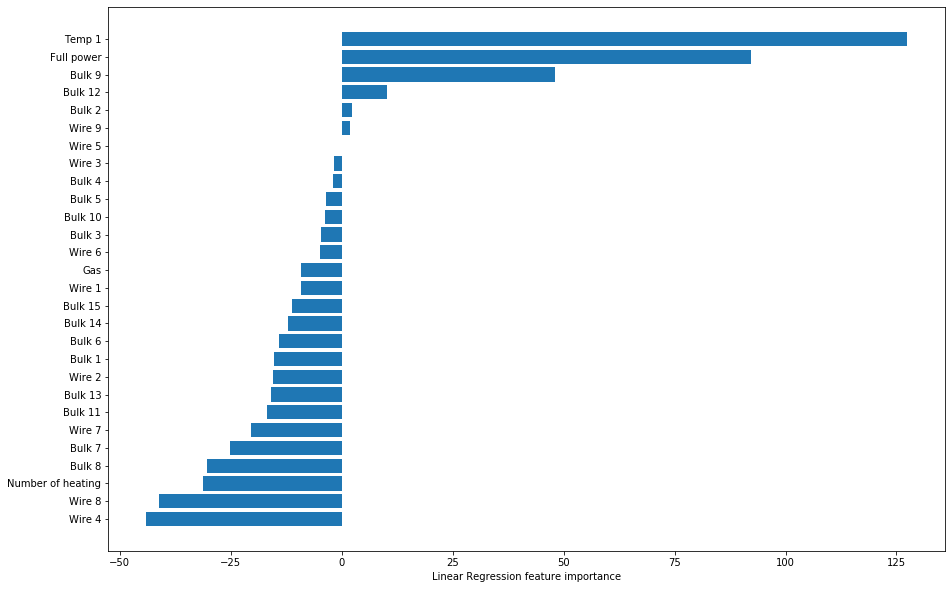

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = lr.coef_.argsort()
plt.barh(X_test.columns.values[sorted_idx], lr.coef_[sorted_idx])
plt.xlabel("Linear Regression feature importance")

**Random Forest**

In [20]:
%%time
param_rf_grid = {'n_estimators': [100, 300, 500], 
                 'max_depth': [2, 4, 6], 
                 'min_samples_split': [2, 5, 8], 
                 'max_features': ['auto', 'sqrt', 'log2', None],
#                'random_state' : [12345]
                }

grid_rf = GridSearchCV(RandomForestRegressor(random_state=RND), 
                       param_rf_grid, 
                       cv=5,
                       scoring='neg_mean_absolute_error')
grid_rf.fit(X_train, y_train)
params_rf = grid_rf.best_params_
rf = RandomForestRegressor(**params_rf, random_state=RND)
rf.fit(X_train, y_train)
pred_test = rf.predict(X_test)
print(params_rf)
print("MAE on test: ", mean_absolute_error(y_test, pred_test))

{'max_depth': 6, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
MAE on test:  6.722866031044739
CPU times: user 9min 13s, sys: 2.48 s, total: 9min 15s
Wall time: 9min 20s


Text(0.5, 0, 'Random Forest feature importance')

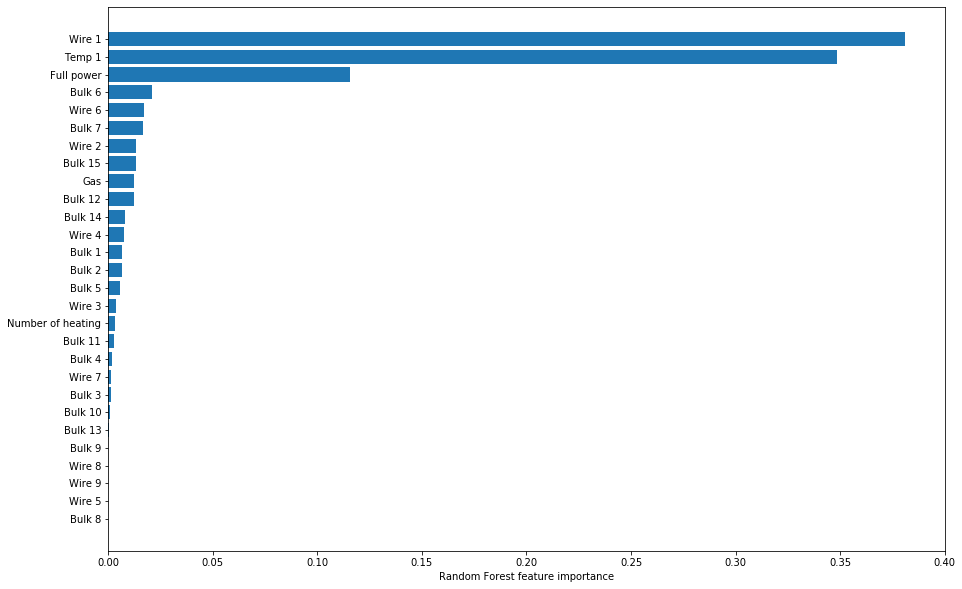

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_test.columns.values[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest feature importance")

**LGBMRegressor**

In [25]:
%%time
param_lgbm_grid = {'boosting_type' : ['gbdt'],
                  'n_estimators': [500], 
                  'learning_rate': [0.01, 0.03, 0.1, 0.2],
                  'max_depth': [3, 5, 7],
#                  'random_state' : [12345]
                  }

grid_lgbm = GridSearchCV(LGBMRegressor(random_state=RND), 
                        param_lgbm_grid, 
                        cv=5, 
                        scoring='neg_mean_absolute_error'
                       ) 
grid_lgbm.fit(X_train, y_train)
params_lgbm = grid_lgbm.best_params_
lgbm = LGBMRegressor(**params_lgb)
lgbm.fit(X_train, y_train)
pred_test = lgbm.predict(X_test) 
print(params_lgbm)
print("MAE on test: ", mean_absolute_error(y_test, pred_test))

{'boosting_type': 'gbdt', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 500}
MAE on test:  6.270732244216889
CPU times: user 46min 9s, sys: 17.9 s, total: 46min 27s
Wall time: 46min 41s


In [26]:
lgbm.feature_importances_

array([533, 136, 500, 335, 134,   7,   0,   0,  27,   0,   0,   0, 103,
         0,  81,  48,  28, 113,   0,   0,   0,  12,  60, 145,   0, 254,
        72, 218], dtype=int32)

Text(0.5, 0, 'LGBMRegressor feature importance')

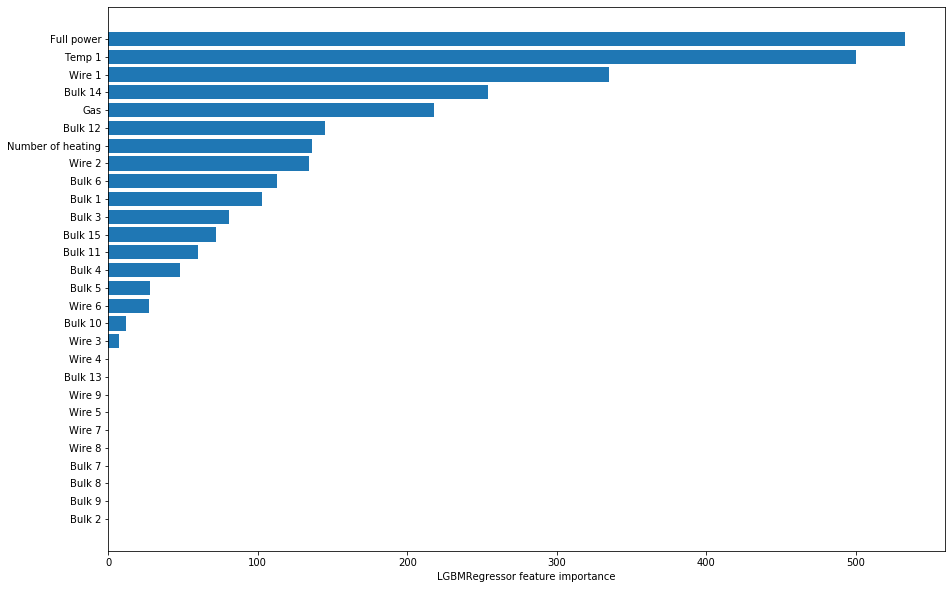

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
sorted_idx = lgbm.feature_importances_.argsort()
plt.barh(X_test.columns.values[sorted_idx], lgbm.feature_importances_[sorted_idx])
plt.xlabel("LGBMRegressor feature importance")

 **Вывод**
 
Таким образом мы подготовили данные и обучили модели. Определили важность признаков для каждой модели. С помощью метрики MAE сравнили их эффективность. 

Лучший результат показала модель LGBMRegressor: MAE on test: 6.27 



# Итог

Мы провели анализ данных и составили план работы:
    1. Подготовка и анализ данных
    2. Предобработка данных
    3. Обучение моделей
    4. Вывод


1. Первым этапами работы являются:
    - Импортировали необходимые библиотеки
    - Загрузили датасеты
    - Провели первичный осмотр каждого датасета
    - Определяли пропуски и дубликаты
    - Проверили данные на аномальность


2. Следуя плану, предобработали данные, а именно:
    - Заполнили пропуски
    - Изменили формат данных в некоторых столбцах
    - Убрали объекты, не имеющие достаточно признаков для изучения
    - Проверили признаки на мультиколлиниарность
    - Масштабировали количественные признаки 


3. Затем, подготовили датасет для обучения:
    - Определили целевой признак
    - Поделили датасет на выборки: Обучающаю и тестовую
    - Выбрали 3 модели для работы: Linear Regression, Random Forest, LGBMRegression
    - Обучили каждую модель и предсказали на тестовой выборке
    - Сравнили результаты по метрике MAE
    - Определили важность признаков для каждой модели


4. Последний этап:
    - Определили лучшую модель и результат метрики (LGBMRegressor МАЕ: 6.27)
    - Написали вывод